In [31]:
import os
from datetime import datetime
import time

import numpy as np 
import pandas as pd 
import json
from pandas.io.json import json_normalize
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import xgboost as xgb

In [2]:
def load_df(csv_path='input/train.csv', nrows=None):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']
    
    df = pd.read_csv(csv_path,
                              converters={column: json.loads for column in JSON_COLUMNS}, 
                              dtype={'fullVisitorId': 'str'}, # Important!!
                              nrows=nrows)
    
    for column in JSON_COLUMNS:
        column_as_df = json_normalize(df[column])
        column_as_df.columns = ["{0}.{1}".format(column, subcolumn) for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
    print("Loaded {0}. Shape: {1}".format(os.path.basename(csv_path), df.shape))
    return df

In [5]:
train_data_path = 'input/train.csv'
test_data_path = 'input/test.csv'
train_df = load_df(train_data_path)
test_df = load_df(test_data_path)

Loaded train.csv. Shape: (903653, 55)
Loaded test.csv. Shape: (804684, 53)


In [6]:
target = train_df['totals.transactionRevenue'].fillna(0).astype(float)
target = target.apply(lambda x: np.log1p(x))
del train_df['totals.transactionRevenue']

In [7]:
columns = [col for col in train_df.columns if train_df[col].nunique() > 1]
#____________________________
train_df = train_df[columns]
test_df = test_df[columns]
print(columns)

['channelGrouping', 'date', 'fullVisitorId', 'sessionId', 'visitId', 'visitNumber', 'visitStartTime', 'device.browser', 'device.deviceCategory', 'device.isMobile', 'device.operatingSystem', 'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country', 'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region', 'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews', 'trafficSource.adContent', 'trafficSource.adwordsClickInfo.adNetworkType', 'trafficSource.adwordsClickInfo.gclId', 'trafficSource.adwordsClickInfo.page', 'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign', 'trafficSource.keyword', 'trafficSource.medium', 'trafficSource.referralPath', 'trafficSource.source']


In [8]:
trn_len = train_df.shape[0]
merged_df = pd.concat([train_df, test_df])

In [9]:
merged_df['diff_visitId_time'] = merged_df['visitId'] - merged_df['visitStartTime']
merged_df['diff_visitId_time'] = (merged_df['diff_visitId_time'] != 0).astype(int)
del merged_df['visitId']

In [10]:
del merged_df['sessionId']

In [15]:
format_str = '%Y%m%d' 
merged_df['formated_date'] = merged_df['date'].apply(lambda x: datetime.strptime(str(x), format_str))
merged_df['WoY'] = merged_df['formated_date'].apply(lambda x: x.isocalendar()[1])
merged_df['month'] = merged_df['formated_date'].apply(lambda x:x.month)
merged_df['quarter_month'] = merged_df['formated_date'].apply(lambda x:x.day//8)
merged_df['weekday'] = merged_df['formated_date'].apply(lambda x:x.weekday())

del merged_df['date']
del merged_df['formated_date']

In [18]:
merged_df['formated_visitStartTime'] = merged_df['visitStartTime'].apply(
    lambda x: time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(x)))
merged_df['formated_visitStartTime'] = pd.to_datetime(merged_df['formated_visitStartTime'])
merged_df['visit_hour'] = merged_df['formated_visitStartTime'].apply(lambda x: x.hour)

del merged_df['visitStartTime']
del merged_df['formated_visitStartTime']

In [19]:
for col in merged_df.columns:
    if col in ['fullVisitorId', 'month', 'quarter_month', 'weekday', 'visit_hour', 'WoY']: continue
    if merged_df[col].dtypes == object or merged_df[col].dtypes == bool:
        merged_df[col], indexer = pd.factorize(merged_df[col])

train_df = merged_df[:trn_len]
test_df = merged_df[trn_len:]

In [28]:
param = {
    'max_depth': 2,
    'eta': 0.3,
    'eval_metric': 'rmse',
    'subsample': 1,
    'lambda': 1, # L2正則化 default:1
    'alpha': 0, # L1正則化 default:0
}

In [41]:
reg = xgb.XGBRegressor(**param)
                #max_depth=2,
                #learning_rate=0.3,
                #)

In [22]:
target.values.mean()

0.22711817137648913

In [42]:
reg

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.3, eval_metric='rmse', gamma=0, lambda=1,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [32]:
x_train, x_val, y_train, y_val = train_test_split(train_df, target, test_size=0.3, random_state=42)
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(632557, 32)
(632557,)
(271096, 32)
(271096,)


In [43]:
num_iter = 10
reg.fit(X=x_train, y=y_train.values)

XGBRegressor(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.3, eval_metric='rmse', gamma=0, lambda=1,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [38]:
x_train.columns

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x329ce2748>>
Traceback (most recent call last):
  File "/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'
Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x329e18470>>
Traceback (most recent call last):
  File "/Users/takizawatakafumi/anaconda/lib/python3.5/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


Index(['channelGrouping', 'fullVisitorId', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source',
       'diff_visitId_time', 'WoY', 'month', 'quarter_month', 'weekday',
       'visit_hour'],
      dtype='object')

In [45]:
del x_val['fullVisitorId']

In [52]:
reg.score(X=x_val, y=y_val.values)

0.2896639244954822

In [59]:
pred = reg.predict(x_val[:5])

In [51]:
y_val.values[0]

0.0

In [60]:
out = np.exp(pred[0]) - 1 

In [61]:
print(out)

0.0115509033203125


In [63]:
out_df = test_df['fullVisitorId']

In [62]:
train_df.to_csv('input/train_preprocessed.csv')
test_df.to_csv('input/test_preprocessed.csv')

In [64]:
del test_df['fullVisitorId']

In [77]:
test_preprocessed = pd.read_csv('input/test_preprocessed.csv',dtype={'fullVisitorId': 'str'})
print(len(test_preprocessed))

804684


In [80]:
submit_df['PredictedLogRevenue'] = reg.predict(test_df)

In [66]:
out_df['pred']

array([ 0.01662567, -0.01278549, -0.01389956, ...,  3.3317735 ,
        0.1781955 ,  0.86533684], dtype=float32)

In [78]:
submit_df = pd.DataFrame(index=test_preprocessed['fullVisitorId'])
submit_df.head()

""
fullVisitorId
6167871330617112363
0643697640977915618
6059383810968229466
2376720078563423631
2314544520795440038


In [133]:
len(submit_df)

804684

In [74]:
len(pred)

804684

In [75]:
len(test_df)

804684

In [81]:
submit_df.head()

,pred
fullVisitorId,
6167871330617112363,0.016626
0643697640977915618,-0.012785
6059383810968229466,-0.013900
2376720078563423631,-0.021426
2314544520795440038,-0.016822


In [82]:
!mkdir output

In [83]:
submit_df.to_csv('output/submit.csv')

In [84]:
df_grouped = submit_df.groupby('fullVisitorId').sum()
df_grouped.head()

,pred
fullVisitorId,
0000000259678714014,0.441458
0000049363351866189,0.077290
0000053049821714864,-0.015490
0000059488412965267,0.176637
0000085840370633780,-0.016043


In [85]:
df_grouped.to_csv('output/submit.csv')

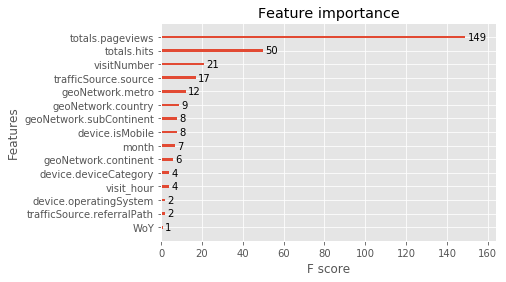

In [86]:
xgb.plot_importance(reg, max_num_features=30)

In [108]:
from sklearn.grid_search import GridSearchCV
params = {
    'learning_rate': [0.03, 0.05, 0.1, 0.3],
    #'max_depth': [2, 3, 5, 10],
    #'subsample': [0, 0.5, 0.8, 1.0],
    #"colsample_bytree": [0.5, 0.7, 1.0],
    #'reg_lambda': [1, 10, 100], # L2正則化 default:1
    #'reg_alpha': [0, 0.3, 0.5, 0.8] # L1正則化 default:0
}

In [109]:
model = xgb.XGBRegressor()
cv = GridSearchCV(model, params, cv = 10, scoring= 'neg_mean_squared_error', n_jobs =-1)

In [110]:
%%time
cv.fit(X=x_train, y=y_train.values)

CPU times: user 1min 52s, sys: 1.52 s, total: 1min 53s
Wall time: 29min 18s


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.03, 0.05, 0.1, 0.3]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [111]:
cv.best_score_

-2.7076142918189086

In [112]:
cv.best_params_

{'learning_rate': 0.3}

In [115]:
params = {
    'learning_rate': [0.3],
    'max_depth': [2, 3, 5, 10],
    #'subsample': [0, 0.5, 0.8, 1.0],
    "colsample_bytree": [0.5, 0.7, 1.0],
    #'reg_lambda': [1, 10, 100], # L2正則化 default:1
    #'reg_alpha': [0, 0.3, 0.5, 0.8] # L1正則化 default:0
}

In [116]:
model = xgb.XGBRegressor()
cv = GridSearchCV(model, params, cv = 10, scoring= 'neg_mean_squared_error', n_jobs =-1)

In [117]:
%%time
cv.fit(X=x_train, y=y_train.values)

CPU times: user 3min 20s, sys: 2.55 s, total: 3min 22s
Wall time: 1h 48min 31s


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.3], 'colsample_bytree': [0.5, 0.7, 1.0], 'max_depth': [2, 3, 5, 10]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [118]:
cv.best_score_

-2.6836855579595063

In [119]:
cv.best_params_

{'colsample_bytree': 1.0, 'learning_rate': 0.3, 'max_depth': 5}

In [120]:
params = {
    'learning_rate': [0.3],
    'max_depth': [5],
    'subsample': [0.5, 0.8, 1.0],
    "colsample_bytree": [1.0],
    'reg_lambda': [1, 10, 100], # L2正則化 default:1
    'reg_alpha': [0, 0.3, 0.5, 0.8] # L1正則化 default:0
}

In [121]:
model = xgb.XGBRegressor()
cv = GridSearchCV(model, params, cv = 10, scoring= 'neg_mean_squared_error', n_jobs =-1)

In [122]:
%%time
cv.fit(X=x_train, y=y_train.values)

CPU times: user 5min 4s, sys: 7.69 s, total: 5min 12s
Wall time: 6h 47min 2s


GridSearchCV(cv=10, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'subsample': [0.5, 0.8, 1.0], 'reg_lambda': [1, 10, 100], 'max_depth': [5], 'reg_alpha': [0, 0.3, 0.5, 0.8], 'learning_rate': [0.3], 'colsample_bytree': [1.0]},
       pre_dispatch='2*n_jobs', refit=True,
       scoring='neg_mean_squared_error', verbose=0)

In [123]:
cv.best_score_

-2.64977974694199

In [124]:
cv.best_params_

{'colsample_bytree': 1.0,
 'learning_rate': 0.3,
 'max_depth': 5,
 'reg_alpha': 0.5,
 'reg_lambda': 100,
 'subsample': 1.0}

In [144]:
param = {
    'n_estimators':150,
    'max_depth': 5,
    'colsample_bytree': 1.0,
    'learning_rate': 0.3,
    'eval_metric': 'rmse',
    'subsample': 1.0,
    'reg_lambda': 100, # L2正則化 default:1
    'reg_alpha': 0.5, # L1正則化 default:0
}

In [145]:
xgb_reg = xgb.XGBRegressor(**param)

In [146]:
xgb_reg

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='rmse', gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.5,
       reg_lambda=100, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)

In [147]:
xgb_reg.fit(X=x_train, y=y_train.values)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, eval_metric='rmse', gamma=0,
       learning_rate=0.3, max_delta_step=0, max_depth=5,
       min_child_weight=1, missing=None, n_estimators=150, n_jobs=1,
       nthread=None, objective='reg:linear', random_state=0, reg_alpha=0.5,
       reg_lambda=100, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)

In [148]:
print('train score')
print(xgb_reg.score(X=x_train, y=y_train.values))
print('val score')
print(xgb_reg.score(X=x_val, y=y_val.values))

train score
0.40904571335181195
val score
0.33388546681420417


In [149]:
submit_df['PredictedLogRevenue'] = xgb_reg.predict(test_df)

In [150]:
submit_df.head()

,pred,PredictedLogRevenue
fullVisitorId,,
6167871330617112363,0.016626,-0.004075
0643697640977915618,-0.012785,-0.002083
6059383810968229466,-0.013900,0.007984
2376720078563423631,-0.021426,-0.005692
2314544520795440038,-0.016822,-0.006739


In [132]:
submit_df.to_csv('output/submit_xgboost_grid_searched.csv')

In [152]:
df_grouped = submit_df.groupby('fullVisitorId').sum()
del df_grouped['pred']
df_grouped.head()

,PredictedLogRevenue
fullVisitorId,
0000000259678714014,-0.047430
0000049363351866189,0.003814
0000053049821714864,-0.004970
0000059488412965267,0.118535
0000085840370633780,-0.001746


In [153]:
df_grouped.to_csv('output/submit_xgboost_grid_searched_2.csv')

In [138]:
df_grouped.head()

,PredictedLogRevenue
fullVisitorId,
0000000259678714014,-0.140034
0000049363351866189,-0.002930
0000053049821714864,-0.004992
0000059488412965267,0.050905
0000085840370633780,-0.000393


In [137]:
del df_grouped['pred']

In [141]:
params = {
    'learning_rate': [0.3],
    'max_depth': [5],
    'subsample': [1.0],
    "colsample_bytree": [1.0],
    'reg_lambda': [100], # L2正則化 default:1
    'reg_alpha': [0.5], # L1正則化 default:0
    'n_estimators':[50, 100, 150, 200]
}

In [142]:
model = xgb.XGBRegressor()
cv = GridSearchCV(model, params, cv = 10, scoring= 'neg_mean_squared_error', n_jobs =-1)

In [143]:
%%time
cv.fit(X=x_train, y=y_train.values)
print(cv.best_score_)
print(cv.best_params_)

-2.6482317570961644
{'subsample': 1.0, 'reg_lambda': 100, 'n_estimators': 150, 'max_depth': 5, 'reg_alpha': 0.5, 'learning_rate': 0.3, 'colsample_bytree': 1.0}
CPU times: user 3min 59s, sys: 2.19 s, total: 4min 1s
Wall time: 1h 19s


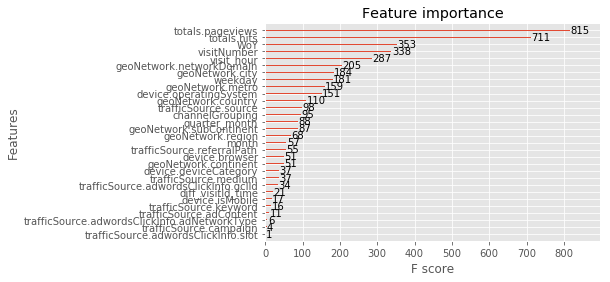

In [154]:
xgb.plot_importance(xgb_reg, max_num_features=30)

In [156]:
train_df.columns

Index(['channelGrouping', 'fullVisitorId', 'visitNumber', 'device.browser',
       'device.deviceCategory', 'device.isMobile', 'device.operatingSystem',
       'geoNetwork.city', 'geoNetwork.continent', 'geoNetwork.country',
       'geoNetwork.metro', 'geoNetwork.networkDomain', 'geoNetwork.region',
       'geoNetwork.subContinent', 'totals.hits', 'totals.pageviews',
       'trafficSource.adContent',
       'trafficSource.adwordsClickInfo.adNetworkType',
       'trafficSource.adwordsClickInfo.gclId',
       'trafficSource.adwordsClickInfo.page',
       'trafficSource.adwordsClickInfo.slot', 'trafficSource.campaign',
       'trafficSource.keyword', 'trafficSource.medium',
       'trafficSource.referralPath', 'trafficSource.source',
       'diff_visitId_time', 'WoY', 'month', 'quarter_month', 'weekday',
       'visit_hour'],
      dtype='object')